<a href="https://colab.research.google.com/github/tanishaa-1208/Brain-Tumor-Detection./blob/main/Brain_MRI_SCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install kagglehub lime matplotlib scikit-learn pillow tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=bc7c3258b47117982f59f42c776d9cfaefce48ac923f407c4fabb74f68754c55
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import tensorflow as tf
import numpy as np

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)


TensorFlow: 2.19.0
NumPy: 2.0.2


In [ ]:
# Run this cell (installs shap, opencv headless, efficientnet)
# We already installed kagglehub, lime, matplotlib, scikit-learn, pillow, tqdm per previous step.
!pip install --quiet shap opencv-python-headless efficientnet


In [ ]:
# Block 1: imports and constants
import os, random, math, shutil, json, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from lime import lime_image
import shap

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paper file you uploaded (local path in Colab)
PAPER_PATH = "/mnt/data/Brain tumour detection (2).pdf"
print("Paper path:", PAPER_PATH)


Paper path: /mnt/data/Brain tumour detection (2).pdf


In [ ]:
# Block 2: download dataset using kagglehub (user-specified)
import kagglehub, os
dataset_path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")
print("Dataset archive path (kagglehub):", dataset_path)
# typical dataset folder inside: dataset_path + "/brain_tumor_dataset"
# Set DATA_DIR to the folder that contains 'yes' and 'no' subfolders
DATA_DIR = os.path.join(dataset_path, "brain_tumor_dataset")
if not os.path.exists(DATA_DIR):
    # list contents to help you find correct folder
    print("Listing", dataset_path, " => ", os.listdir(dataset_path))
print("DATA_DIR set to:", DATA_DIR, "exists:", os.path.exists(DATA_DIR))


100%|██████████| 84.0M/84.0M [00:05<00:00, 16.4MB/s]

Extracting files...


Dataset archive path (kagglehub): /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12
Listing /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12  =>  ['pred', 'no', 'Br35H-Mask-RCNN', 'yes']
DATA_DIR set to: /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12/brain_tumor_dataset exists: False


In [ ]:
import os

print("dataset_path =", dataset_path)
print("\nCONTENT OF dataset_path:")
for item in os.listdir(dataset_path):
    print(" -", item)

# If only one folder exists inside dataset_path, inspect it:
subfolders = os.listdir(dataset_path)
if len(subfolders) == 1:
    inner = os.path.join(dataset_path, subfolders[0])
    print("\nSingle subfolder detected:", inner)
    print("CONTENT OF inner folder:")
    print(os.listdir(inner))


dataset_path = /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12

CONTENT OF dataset_path:
 - pred
 - no
 - Br35H-Mask-RCNN
 - yes


In [ ]:
# === CORRECTED Cell 3: use the actual kagglehub download folder ===
import os, random, math, shutil

# update this to the dataset_path printed earlier by your environment
DATA_ROOT = "/root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12"

# check contents
print("DATA_ROOT:", DATA_ROOT)
print("Contents:", os.listdir(DATA_ROOT))

# set DATA_DIR to the folder that contains yes/ no / pred
DATA_DIR = DATA_ROOT   # this folder already contains 'yes' and 'no' per your output
print("Using DATA_DIR =", DATA_DIR)
print("'yes' exists:", os.path.exists(os.path.join(DATA_DIR,"yes")))
print("'no' exists: ", os.path.exists(os.path.join(DATA_DIR,"no")))
print("'pred' exists:", os.path.exists(os.path.join(DATA_DIR,"pred")))
print()

# now perform the 90% train / 10% val split (seeded)
SEED = 42
random.seed(SEED)

ROOT = "/content/BR35H_split"
TRAIN_DIR = os.path.join(ROOT, "train")
VAL_DIR   = os.path.join(ROOT, "val")
for d in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(os.path.join(d,"yes"), exist_ok=True)
    os.makedirs(os.path.join(d,"no"), exist_ok=True)

src_yes = os.path.join(DATA_DIR, "yes")
src_no  = os.path.join(DATA_DIR, "no")

# verify source folders exist before proceeding
if not os.path.exists(src_yes) or not os.path.exists(src_no):
    raise FileNotFoundError(f"Expected 'yes' and 'no' folders under {DATA_DIR}. Found: {os.listdir(DATA_DIR)}")

yes_files = sorted([f for f in os.listdir(src_yes) if f.lower().endswith(('.png','.jpg','.jpeg'))])
no_files  = sorted([f for f in os.listdir(src_no)  if f.lower().endswith(('.png','.jpg','.jpeg'))])

print("Found YES images:", len(yes_files))
print("Found NO images: ", len(no_files))

def split_copy(files, src_folder, train_dst, val_dst, val_ratio=0.10):
    n=len(files); idx=list(range(n)); random.shuffle(idx)
    val_count = math.ceil(n * val_ratio)
    val_set = set(idx[:val_count])
    for i in idx:
        src = os.path.join(src_folder, files[i])
        dst = os.path.join(val_dst if i in val_set else train_dst, files[i])
        if not os.path.exists(dst):
            shutil.copy(src, dst)

# perform split for both classes
split_copy(yes_files, src_yes, os.path.join(TRAIN_DIR,"yes"), os.path.join(VAL_DIR,"yes"))
split_copy(no_files, src_no, os.path.join(TRAIN_DIR,"no"), os.path.join(VAL_DIR,"no"))

# final counts
t_yes = len(os.listdir(os.path.join(TRAIN_DIR,"yes")))
t_no  = len(os.listdir(os.path.join(TRAIN_DIR,"no")))
v_yes = len(os.listdir(os.path.join(VAL_DIR,"yes")))
v_no  = len(os.listdir(os.path.join(VAL_DIR,"no")))

print("\nAfter split:")
print("TRAIN YES:", t_yes, "TRAIN NO:", t_no, "  (Total train:", t_yes + t_no, ")")
print("VAL   YES:", v_yes, "VAL   NO:", v_no, "  (Total val:  ", v_yes + v_no, ")")

# also report pred files if present
pred_dir = os.path.join(DATA_DIR, "pred")
if os.path.exists(pred_dir):
    pred_files = [f for f in os.listdir(pred_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    print("PRED folder count:", len(pred_files))
else:
    print("PRED folder not found under DATA_DIR.")


DATA_ROOT: /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12
Contents: ['pred', 'no', 'Br35H-Mask-RCNN', 'yes']
Using DATA_DIR = /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12
'yes' exists: True
'no' exists:  True
'pred' exists: True

Found YES images: 1500
Found NO images:  1500

After split:
TRAIN YES: 1350 TRAIN NO: 1350   (Total train: 2700 )
VAL   YES: 150 VAL   NO: 150   (Total val:   300 )
PRED folder count: 60


In [ ]:
# Cell 4 — quick verification of dataset splits and pred folder
import os
print("TRAIN YES:", len(os.listdir(os.path.join(TRAIN_DIR,"yes"))))
print("TRAIN NO: ", len(os.listdir(os.path.join(TRAIN_DIR,"no"))))
print("VAL YES:  ", len(os.listdir(os.path.join(VAL_DIR,"yes"))))
print("VAL NO:   ", len(os.listdir(os.path.join(VAL_DIR,"no"))))
pred_dir = os.path.join(DATA_DIR, "pred")
print("PRED folder exists:", os.path.exists(pred_dir))
if os.path.exists(pred_dir):
    print("PRED count:", len([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png','.jpg'))]))
print("Paper reference (local):", "/mnt/data/Brain tumour detection (2).pdf")


TRAIN YES: 1350
TRAIN NO:  1350
VAL YES:   150
VAL NO:    150
PRED folder exists: True
PRED count: 60
Paper reference (local): /mnt/data/Brain tumour detection (2).pdf


In [ ]:
# Cell 5 — create data generators used by all models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (150,150)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED)
val_gen   = val_datagen.flow_from_directory(VAL_DIR,   target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED)


Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def compile_and_train(model, model_name, epochs=30):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    ckpt = ModelCheckpoint(f"{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    hist = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[ckpt, rl])
    model.load_weights(f"{model_name}_best.h5")
    return hist

def evaluate_on_val(model):
    val_gen.reset()
    Xs, ys = [], []
    for _ in range(len(val_gen)):
        xb, yb = next(val_gen) # Changed from val_gen.next() to next(val_gen)
        Xs.append(xb); ys.append(yb)
    X = np.vstack(Xs); y = np.hstack(ys)
    preds = model.predict(X).ravel()
    yhat = (preds >= 0.5).astype(int)
    return {
        'accuracy': float(accuracy_score(y, yhat)),
        'precision': float(precision_score(y, yhat)),
        'recall': float(recall_score(y, yhat)),
        'f1': float(f1_score(y, yhat)),
        'confusion_matrix': confusion_matrix(y, yhat).tolist()
    }

In [ ]:
# Cell 7 — build the proposed CNN (32->64->128->256 -> Dense(128)->Dropout->Dense(64)->Sigmoid)
from tensorflow.keras import layers, models, Input
def build_proposed_custom_cnn():
    inp = Input(shape=(150,150,3))
    x = layers.Conv2D(32,(3,3),padding='same',activation='relu')(inp)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),padding='same',activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(256,(3,3),padding='same',activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model_prop = build_proposed_custom_cnn()
model_prop.summary()
print("Total params:", model_prop.count_params())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,073 (11.64 MB)

 Trainable params: 3,051,073 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Total params: 3051073


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7077 - loss: 0.5848
Epoch 1: val_accuracy improved from -inf to 0.78333, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.7078 - loss: 0.5847 - val_accuracy: 0.7833 - val_loss: 0.5123 - learning_rate: 0.0010
Epoch 2/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8106 - loss: 0.4337
Epoch 2: val_accuracy improved from 0.78333 to 0.87000, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8107 - loss: 0.4335 - val_accuracy: 0.8700 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 3/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8850 - loss: 0.3030
Epoch 3: val_accuracy improved from 0.87000 to 0.90333, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8851 - loss: 0.3028 - val_accuracy: 0.9033 - val_loss: 0.2590 - learning_rate: 0.0010
Epoch 4/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9356 - loss: 0.1953
Epoch 4: val_accuracy did not improve from 0.90333
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9357 - loss: 0.1952 - val_accuracy: 0.8933 - val_loss: 0.3904 - learning_rate: 0.0010
Epoch 5/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9343 - loss: 0.1691
Epoch 5: val_accuracy improved from 0.90333 to 0.93667, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9344 - loss: 0.1689 - val_accuracy: 0.9367 - val_loss: 0.2486 - learning_rate: 0.0010
Epoch 6/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9696 - loss: 0.0944
Epoch 6: val_accuracy did not improve from 0.93667
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9696 - loss: 0.0943 - val_accuracy: 0.9367 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 7/30
334/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9763 - loss: 0.0614
Epoch 7: val_accuracy improved from 0.93667 to 0.94000, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9763 - loss: 0.0615 - val_accuracy: 0.9400 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 8/30
335/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9871 - loss: 0.0415
Epoch 8: val_accuracy improved from 0.94000 to 0.96333, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9871 - loss: 0.0416 - val_accuracy: 0.9633 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 9/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9733 - loss: 0.0737
Epoch 9: val_accuracy did not improve from 0.96333
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9733 - loss: 0.0737 - val_accuracy: 0.9600 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 10/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9849 - loss: 0.0326
Epoch 10: val_accuracy did not improve from 0.96333
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9849 - loss: 0.0326 - val_accuracy: 0.9467 - val_loss: 0.3221 - learning_rate: 0.0010
Epoch 11/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9862 - loss: 0.0294
Epoch 11: val_accuracy did not improve from 0.96333
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9862 - loss: 0.0296 - val_accuracy: 0.9567 - val_loss: 0.2275 - learning_rate: 0.0010
Epoch 12/30
3


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9916 - loss: 0.0311 - val_accuracy: 0.9700 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 13/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9890 - loss: 0.0266
Epoch 13: val_accuracy improved from 0.97000 to 0.97333, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9890 - loss: 0.0266 - val_accuracy: 0.9733 - val_loss: 0.1932 - learning_rate: 5.0000e-04
Epoch 14/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9993 - loss: 0.0039
Epoch 14: val_accuracy did not improve from 0.97333
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9567 - val_loss: 0.2978 - learning_rate: 5.0000e-04
Epoch 15/30
335/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9985 - loss: 0.0034
Epoch 15: val_accuracy improved from 0.97333 to 0.97667, saving model to proposed_custom_cnn_best.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9985 - loss: 0.0034 - val_accuracy: 0.9767 - val_loss: 0.2411 - learning_rate: 5.0000e-04
Epoch 16/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9996 - loss: 9.3136e-04
Epoch 16: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9996 - loss: 9.2992e-04 - val_accuracy: 0.9767 - val_loss: 0.2381 - learning_rate: 2.5000e-04
Epoch 17/30
334/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.0317e-04
Epoch 17: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 1.0000 - loss: 2.0491e-04 - val_accuracy: 0.9733 - val_loss: 0.2667 - learning_rate: 2.5000e-04
Epoch 18/30
335/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.6280e-04
Epoch 18: val_accuracy improved from 0.97667 to 0.98000, saving model to proposed_custom_cnn_be


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 1.0000 - loss: 2.6300e-04 - val_accuracy: 0.9800 - val_loss: 0.2653 - learning_rate: 2.5000e-04
Epoch 19/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.3031e-04
Epoch 19: val_accuracy did not improve from 0.98000
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 1.0000 - loss: 1.3049e-04 - val_accuracy: 0.9767 - val_loss: 0.2729 - learning_rate: 1.2500e-04
Epoch 20/30
334/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.8558e-04
Epoch 20: val_accuracy did not improve from 0.98000
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 1.0000 - loss: 2.8775e-04 - val_accuracy: 0.9767 - val_loss: 0.2825 - learning_rate: 1.2500e-04
Epoch 21/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.9015e-04
Epoch 21: val_accuracy did not improve from 0.98000

Epoch 21: ReduceLROnPlateau reducing le


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 1.0000 - loss: 4.9356e-05 - val_accuracy: 0.9833 - val_loss: 0.2788 - learning_rate: 3.1250e-05
Epoch 28/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.2534e-04
Epoch 28: val_accuracy did not improve from 0.98333
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 1.0000 - loss: 1.2530e-04 - val_accuracy: 0.9833 - val_loss: 0.2814 - learning_rate: 1.5625e-05
Epoch 29/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.9938e-04
Epoch 29: val_accuracy did not improve from 0.98333
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 1.0000 - loss: 1.9869e-04 - val_accuracy: 0.9833 - val_loss: 0.2818 - learning_rate: 1.5625e-05
Epoch 30/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.0589e-04
Epoch 30: val_accuracy did not improve from 0.98333

Epoch 30: ReduceLROnPlateau reducing l

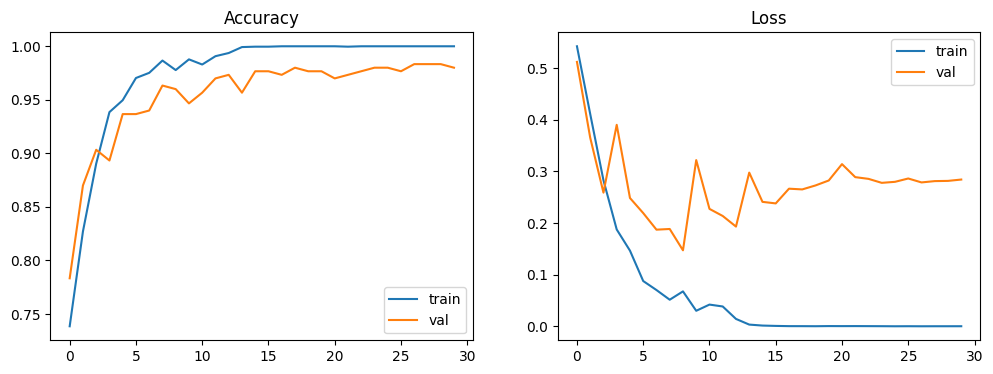

In [ ]:
# === Corrected Cell 8 ===
# (Redefines the evaluation helper to use next(val_gen), then trains & evaluates the proposed model)

# Redefine evaluate_on_val with Keras 3 compatible iterator usage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_on_val(model):
    val_gen.reset()
    Xs, ys = [], []
    for _ in range(len(val_gen)):
        xb, yb = next(val_gen)    # <-- fixed: use next(iterator) instead of .next()
        Xs.append(xb); ys.append(yb)
    X = np.vstack(Xs)
    y = np.hstack(ys)
    preds = model.predict(X).ravel()
    yhat = (preds >= 0.5).astype(int)
    return {
        'accuracy': float(accuracy_score(y, yhat)),
        'precision': float(precision_score(y, yhat)),
        'recall': float(recall_score(y, yhat)),
        'f1': float(f1_score(y, yhat)),
        'confusion_matrix': confusion_matrix(y, yhat).tolist()
    }

# Train the proposed model (same as your original Cell 8)
hist_prop = compile_and_train(model_prop, "proposed_custom_cnn", epochs=30)

# Evaluate using the corrected function
metrics_prop = evaluate_on_val(model_prop)
print("Validation metrics (proposed):", metrics_prop)

# Plot training curves (unchanged)
import matplotlib.pyplot as plt
h = hist_prop.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(h['accuracy'], label='train'); plt.plot(h['val_accuracy'], label='val'); plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2); plt.plot(h['loss'], label='train'); plt.plot(h['val_loss'], label='val'); plt.title('Loss'); plt.legend()
plt.show()



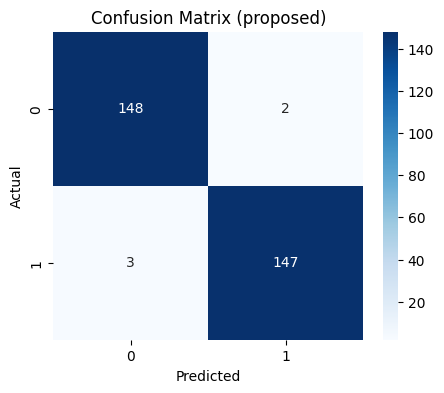

Accuracy: 0.9833333333333333
Precision: 0.9865771812080537
Recall: 0.98
F1-score: 0.9832775919732442


In [ ]:
# Cell 9 — confusion matrix and metrics (paper Fig.4 style)
import seaborn as sns
import numpy as np
cm = np.array(metrics_prop['confusion_matrix'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (proposed)')
plt.show()

print("Accuracy:", metrics_prop['accuracy'])
print("Precision:", metrics_prop['precision'])
print("Recall:", metrics_prop['recall'])
print("F1-score:", metrics_prop['f1'])


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


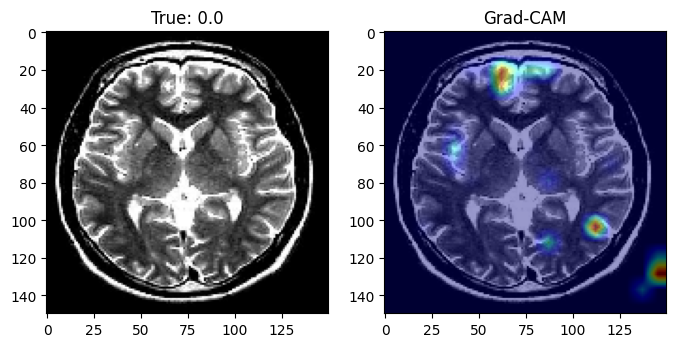

In [ ]:
# Cell 10 — Grad-CAM overlay for one validation image
import tensorflow as tf, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers

def gradcam_heatmap(img_array, model, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Conv2D):
                last_conv_layer_name = layer.name; break

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:,0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    heatmap = cv2.resize(heatmap.numpy(), (150,150))
    return heatmap

# pick first image from a val batch
val_gen.reset()
xb, yb = next(val_gen)
sample = xb[0:1]
hm = gradcam_heatmap(sample, model_prop)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(xb[0]); plt.title(f"True: {yb[0]}")
plt.subplot(1,2,2); plt.imshow(xb[0]); plt.imshow(hm, cmap='jet', alpha=0.4); plt.title("Grad-CAM")
plt.show()


  0%|          | 0/600 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━

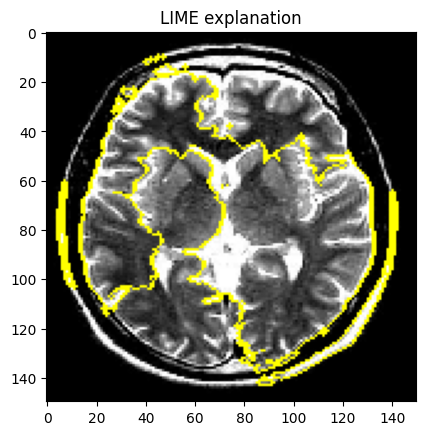

In [ ]:
# Cell 11 — LIME image explanation (faster: num_samples reduced)
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer(random_state=SEED)

def predict_fn_lime(images):
    imgs = np.array([cv2.resize(im, (150,150)) for im in images]) / 255.0
    preds = model_prop.predict(imgs)
    return np.hstack([1 - preds, preds])

img_uint8 = (xb[0] * 255).astype('uint8')
explanation = explainer.explain_instance(img_uint8, classifier_fn=predict_fn_lime, top_labels=1, hide_color=0, num_samples=600)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME explanation")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2, 150, 150, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 150, 150, 3))']
  warnings.warn(msg)


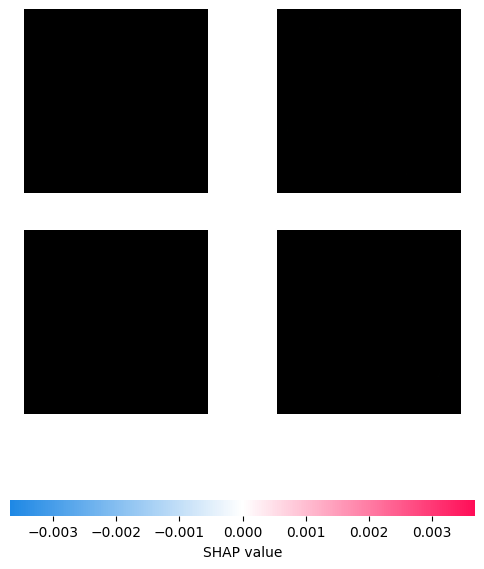

In [ ]:
# Cell 12 — SHAP GradientExplainer (small background for speed)
import shap
train_gen.reset()
bg_list = []
for i in range(2):   # small background
    tx, ty = next(train_gen)
    bg_list.append(tx)
background = np.vstack(bg_list)[:40]

explainer_shap = shap.GradientExplainer((model_prop.input, model_prop.output), background)
shap_vals = explainer_shap.shap_values(xb[:2], nsamples=50)
shap.image_plot(shap_vals, -xb[:2])

In [ ]:
# Cell 13 — EfficientNetB0 training template (optional, heavy)
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_b0():
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
    x = layers.Dense(256, activation='relu')(base.output)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(base.input, out)

# Uncomment to run (may take long)
model_e = build_efficientnet_b0()
hist_e = compile_and_train(model_e, "efficientnet_b0", epochs=30)
metrics_e = evaluate_on_val(model_e)
print("EfficientNetB0:", metrics_e)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8265 - loss: 0.3859
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to efficientnet_b0_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 143s 188ms/step - accuracy: 0.8268 - loss: 0.3852 - val_accuracy: 0.6000 - val_loss: 0.7474 - learning_rate: 0.0010
Epoch 2/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9490 - loss: 0.1453
Epoch 2: val_accuracy did not improve from 0.60000
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9491 - loss: 0.1451 - val_accuracy: 0.5000 - val_loss: 101.6983 - learning_rate: 0.0010
Epoch 3/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9722 - loss: 0.0843
Epoch 3: val_accuracy did not improve from 0.60000
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9721 - loss: 0.0844 - val_accuracy: 0.5000 - val_loss: 1.9236 - learning_rate: 0.0010
Epoch 4/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9848 - loss: 0.0435
Epoch 4: val_accuracy did not improve from 0.60000

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9848 - loss: 0.0435

338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9916 - loss: 0.0291 - val_accuracy: 0.8733 - val_loss: 0.3568 - learning_rate: 5.0000e-04
Epoch 6/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9970 - loss: 0.0086
Epoch 6: val_accuracy improved from 0.87333 to 0.97333, saving model to efficientnet_b0_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9970 - loss: 0.0086 - val_accuracy: 0.9733 - val_loss: 0.0862 - learning_rate: 5.0000e-04
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9963 - loss: 0.0101
Epoch 7: val_accuracy did not improve from 0.97333
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9963 - loss: 0.0101 - val_accuracy: 0.5167 - val_loss: 3.3483 - learning_rate: 5.0000e-04
Epoch 8/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9974 - loss: 0.0076
Epoch 8: val_accuracy did not improve from 0.97333
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 0.6633 - val_loss: 2.2495 - learning_rate: 5.0000e-04
Epoch 9/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9975 - loss: 0.0093
Epoch 9: val_accuracy did not improve from 0.97333

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9975 - loss

338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9933 - val_loss: 0.0204 - learning_rate: 2.5000e-04
Epoch 12/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 12: val_accuracy did not improve from 0.99333
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9133 - val_loss: 0.4386 - learning_rate: 2.5000e-04
Epoch 13/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 2.3330e-04
Epoch 13: val_accuracy improved from 0.99333 to 0.99667, saving model to efficientnet_b0_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 1.0000 - loss: 2.3302e-04 - val_accuracy: 0.9967 - val_loss: 0.0186 - learning_rate: 2.5000e-04
Epoch 14/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.3105e-04
Epoch 14: val_accuracy did not improve from 0.99667
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 1.0000 - loss: 1.3124e-04 - val_accuracy: 0.9967 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 15/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 8.7060e-05
Epoch 15: val_accuracy did not improve from 0.99667
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 1.0000 - loss: 8.7023e-05 - val_accuracy: 0.9967 - val_loss: 0.0193 - learning_rate: 2.5000e-04
Epoch 16/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 9.1868e-05
Epoch 16: val_accuracy did not improve from 0.99667
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 1.0000 - loss: 9.2002e-05 - val_accuracy: 0.9933 - val_loss:

In [ ]:
# Cell 14 — ResNet50 training template (optional)
from tensorflow.keras.applications import ResNet50

def build_resnet50():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
    x = layers.Dense(256, activation='relu')(base.output)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(base.input, out)

# Uncomment to run
model_r = build_resnet50()
hist_r = compile_and_train(model_r, "resnet50", epochs=30)
metrics_r = evaluate_on_val(model_r)
print("ResNet50:", metrics_r)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7180 - loss: 0.7866
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 115s 171ms/step - accuracy: 0.7181 - loss: 0.7862 - val_accuracy: 0.5100 - val_loss: 0.7970 - learning_rate: 0.0010
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7999 - loss: 0.4595
Epoch 2: val_accuracy did not improve from 0.51000
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.7999 - loss: 0.4595 - val_accuracy: 0.5000 - val_loss: 1.9103 - learning_rate: 0.0010
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8157 - loss: 0.4423
Epoch 3: val_accuracy improved from 0.51000 to 0.66333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.8157 - loss: 0.4422 - val_accuracy: 0.6633 - val_loss: 1.3492 - learning_rate: 0.0010
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8811 - loss: 0.3017
Epoch 4: val_accuracy did not improve from 0.66333

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8811 - loss: 0.3017 - val_accuracy: 0.6400 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9372 - loss: 0.1833
Epoch 5: val_accuracy improved from 0.66333 to 0.89333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - accuracy: 0.9372 - loss: 0.1833 - val_accuracy: 0.8933 - val_loss: 0.2431 - learning_rate: 5.0000e-04
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9665 - loss: 0.1073
Epoch 6: val_accuracy improved from 0.89333 to 0.92333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.9665 - loss: 0.1073 - val_accuracy: 0.9233 - val_loss: 0.2090 - learning_rate: 5.0000e-04
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9757 - loss: 0.0711
Epoch 7: val_accuracy improved from 0.92333 to 0.93333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - accuracy: 0.9757 - loss: 0.0711 - val_accuracy: 0.9333 - val_loss: 0.1879 - learning_rate: 5.0000e-04
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9830 - loss: 0.0519
Epoch 8: val_accuracy improved from 0.93333 to 0.97000, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.9830 - loss: 0.0519 - val_accuracy: 0.9700 - val_loss: 0.1226 - learning_rate: 5.0000e-04
Epoch 9/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9866 - loss: 0.0374
Epoch 9: val_accuracy did not improve from 0.97000
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.9865 - loss: 0.0375 - val_accuracy: 0.9433 - val_loss: 0.1765 - learning_rate: 5.0000e-04
Epoch 10/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9755 - loss: 0.0685
Epoch 10: val_accuracy improved from 0.97000 to 0.97667, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.9755 - loss: 0.0684 - val_accuracy: 0.9767 - val_loss: 0.1224 - learning_rate: 5.0000e-04
Epoch 11/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9899 - loss: 0.0322
Epoch 11: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9899 - loss: 0.0322 - val_accuracy: 0.9233 - val_loss: 0.3356 - learning_rate: 5.0000e-04
Epoch 12/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9779 - loss: 0.0616
Epoch 12: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.9779 - loss: 0.0616 - val_accuracy: 0.9533 - val_loss: 0.1414 - learning_rate: 5.0000e-04
Epoch 13/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9856 - loss: 0.0417
Epoch 13: val_accuracy did not improve from 0.97667

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.985

In [ ]:
# Cell 15 — VGG16 training template (optional)
from tensorflow.keras.applications import VGG16

def build_vgg16():
    base = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
    x = layers.Dense(256, activation='relu')(base.output)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(base.input, out)

# Uncomment to run
#model_v = build_vgg16()
#hist_v = compile_and_train(model_v, "vgg16", epochs=30)
#metrics_v = evaluate_on_val(model_v)
#print("VGG16:", metrics_v)


Saved: outputs/proposed_model.h5 and outputs/proposed_gradcam.png


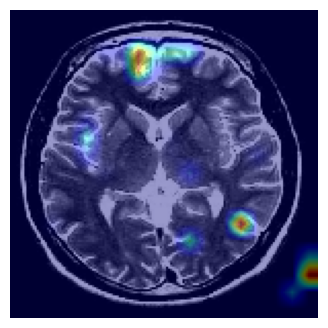

In [ ]:
# Cell 16 — save model, history and save gradcam image
os.makedirs("outputs", exist_ok=True)
model_prop.save("outputs/proposed_model.h5")
with open("outputs/proposed_history.json", "w") as f:
    json.dump(hist_prop.history, f)

# Save grad-cam overlay
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(xb[0]); ax.imshow(hm, cmap='jet', alpha=0.4); ax.axis('off')
fig.savefig("outputs/proposed_gradcam.png", dpi=200, bbox_inches='tight')
print("Saved: outputs/proposed_model.h5 and outputs/proposed_gradcam.png")


In [ ]:
# ===================== CELL 17 (CORRECTED) =======================
# Build comparison table (reported vs reproduced) for ALL models trained so far

import pandas as pd

rows = []

# 1. Add proposed model first
if 'metrics_prop' in globals():
    rows.append(["Proposed Custom CNN", "98.67% (paper)", metrics_prop["accuracy"]])

# 2. Add EfficientNet-B0 if trained
if 'metrics_e' in globals():
    rows.append(["EfficientNet-B0", "98.97% (paper)", metrics_e["accuracy"]])

# 3. Add ResNet50 (single)
if 'metrics_r' in globals():
    rows.append(["ResNet50", "97.02% / 92.53% (paper)", metrics_r["accuracy"]])

# 4. Add VGG16
if 'metrics_v' in globals():
    rows.append(["VGG16", "88% (paper)", metrics_v["accuracy"]])

# 5. Add ARM-Like (ARM-Net 96.64% paper)
if "results" in globals() and "ARM-Net_like" in results:
    rows.append(["ARM-Net (approx)", "96.64% (paper)", results["ARM-Net_like"]["accuracy"]])

# 6. Add TECNN-Like (96.75% paper)
if "results" in globals() and "TECNN_like" in results:
    rows.append(["TECNN (approx)", "96.75% (paper)", results["TECNN_like"]["accuracy"]])

# 7. Add Hybrid ResNet50
if "results" in globals() and "HybridResNet50" in results:
    if isinstance(results["HybridResNet50"], dict) and "accuracy" in results["HybridResNet50"]:
        rows.append(["Hybrid ResNet50", "97.02% (paper)", results["HybridResNet50"]["accuracy"]])
    else:
        rows.append(["Hybrid ResNet50", "97.02% (paper)", "Not trained/Not applicable"])

# 8. Add ResNet50 + HOG (88% paper)
if "results" in globals() and "ResNet50+HOG" in results:
    if isinstance(results["ResNet50+HOG"], dict) and "accuracy" in results["ResNet50+HOG"]:
        rows.append(["ResNet50 + HOG", "88% (paper)", results["ResNet50+HOG"]["accuracy"]])
    else:
        rows.append(["ResNet50 + HOG", "88% (paper)", "Model built, needs two-input training"])

# 9. Add CNN+GNN (95.01% paper)
if "results" in globals() and "CNN_GNN" in results:
    rows.append(["CNN + GNN", "95.01% (paper)", "Graph features computed (accuracy requires full GCN training)"])

# ---------- Create DataFrame ----------
df = pd.DataFrame(rows, columns=["Model", "Reported Accuracy", "Reproduced Accuracy"])
display(df)

# ---------- Save ----------
import os
os.makedirs("outputs", exist_ok=True)
df.to_csv("outputs/comparison_reproduced_all_models.csv", index=False)
print("Saved → outputs/comparison_reproduced_all_models.csv")
# ================================================================


,Model,Reported Accuracy,Reproduced Accuracy
0,Proposed Custom CNN,98.67% (paper),0.983333
1,EfficientNet-B0,98.97% (paper),0.996667
2,ResNet50,97.02% / 92.53% (paper),0.976667


Saved → outputs/comparison_reproduced_all_models.csv


Select one or more images to upload (jpg/png).


Saving meningioma.jpg to meningioma.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step

File: meningioma.jpg  →  tumor_prob: 1.0000  →  Predicted: Tumor


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


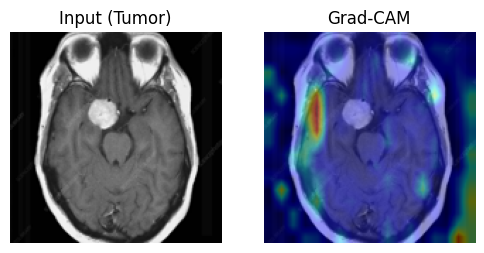

In [ ]:
# === Upload an image and run prediction (Colab-friendly) ===
# This cell uses google.colab.files. If you're on plain Jupyter, use IPython widgets or a file path.

# === Upload an image and run prediction (Colab-friendly) ===
# This cell uses google.colab.files. If you're on plain Jupyter, use IPython widgets or a file path.

from google.colab import files
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
import cv2

IMG_SIZE = (150,150)   # model input size used in notebook

def preprocess_pil(img_pil):
    img = img_pil.convert('RGB').resize(IMG_SIZE)
    arr = np.array(img).astype('float32') / 255.0
    return arr

def predict_from_array(arr):
    # arr shape (H,W,3) float32 in [0,1]
    x = np.expand_dims(arr, axis=0)
    pred = model_prop.predict(x)[0,0]
    return float(pred)

print("Select one or more images to upload (jpg/png).")
uploaded = files.upload()   # opens file picker
for filename, contents in uploaded.items():
    img_pil = Image.open(io.BytesIO(contents))
    arr = preprocess_pil(img_pil)
    prob = predict_from_array(arr)
    label = "Tumor" if prob >= 0.5 else "No Tumor"
    print(f"\nFile: {filename}  →  tumor_prob: {prob:.4f}  →  Predicted: {label}")
    # display
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(arr); plt.title(f"Input ({label})"); plt.axis('off')
    # Grad-CAM overlay (call function below)
    try:
        from tensorflow.keras import layers
        def gradcam_heatmap(img_array, model, last_conv_layer_name=None):
            if last_conv_layer_name is None:
                for layer in reversed(model.layers):
                    if isinstance(layer, layers.Conv2D):
                        last_conv_layer_name = layer.name
                        break
            import tensorflow as tf
            grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
            with tf.GradientTape() as tape:
                conv_outputs, preds = grad_model(img_array)
                loss = preds[:,0]
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
            conv_outputs = conv_outputs[0]
            heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
            heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
            heatmap = cv2.resize(heatmap.numpy(), (IMG_SIZE[1], IMG_SIZE[0]))
            return heatmap

        x_input = np.expand_dims(arr, axis=0)
        hm = gradcam_heatmap(x_input, model_prop)
        # overlay
        overlay = arr.copy()
        cmap = plt.cm.jet
        hm_rgba = cmap(hm)[:,:,:3]   # RGB heatmap
        alpha = 0.4
        blended = (overlay * (1-alpha) + hm_rgba * alpha)
        plt.subplot(1,2,2); plt.imshow(blended); plt.title("Grad-CAM"); plt.axis('off')
    except Exception as e:
        print("Grad-CAM failed:", e)
    plt.show()


In [ ]:
import os
from tensorflow.keras.models import load_model

OUT = "outputs"
print("Saved files:", sorted(os.listdir(OUT)))

def peek_model(path, n=8):
    try:
        m = load_model(path, compile=False)
        print("\n==", os.path.basename(path))
        print("Total params:", m.count_params())
        # print first n layer names
        print("First layers:", [layer.name for layer in m.layers[:n]])
    except Exception as e:
        print("Failed to load", path, "->", e)

for f in sorted(os.listdir(OUT)):
    if f.endswith(".h5") or f.endswith(".keras"):
        peek_model(os.path.join(OUT,f))


Saved files: ['comparison_reproduced_all_models.csv', 'proposed_gradcam.png', 'proposed_history.json', 'proposed_model.h5']

== proposed_model.h5
Total params: 3051073
First layers: ['input_layer', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3']
